In [ ]:
# help from https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb
import pandas as pd

In [ ]:
marke_data = pd.read_csv('marketing_campaign.csv', sep = ";")
marke_data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [ ]:
# using respose as target variable and other two as predictor variable
small_df = marke_data[["NumWebVisitsMonth","NumStorePurchases","Response"]]
small_df.head()

,NumWebVisitsMonth,NumStorePurchases,Response
0,7,4,1
1,5,2,0
2,4,10,0
3,6,4,0
4,5,6,0


In [ ]:
from sklearn.utils import shuffle
small_df = shuffle(small_df)
small_df.reset_index(inplace=True, drop=True)
small_df_train = small_df.iloc[:int(0.7*small_df.shape[0]),:]
small_df_test = small_df.iloc[int(0.7*small_df.shape[0]):,:]

In [ ]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

# Logistic function with both beta and alpha
def logistic(x, beta, gamma, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x['NumStorePurchases']) + np.dot(gamma, x['NumWebVisitsMonth']) + alpha))

store_purchase = small_df_train['NumStorePurchases']
response = small_df_train['Response']
web_visit = small_df_train['NumWebVisitsMonth']

In [ ]:
N_SAMPLES = 10000
with pm.Model() as response_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    gamma = pm.Normal('gamma', mu=0.0, tau=0.01, testval=0.0)

    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * store_purchase + gamma * web_visit + alpha)))
    
    # Create the bernoulli parameter which uses the observed dat
    observed = pm.Bernoulli('obs', p, observed=response)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    model_trace = pm.sample(N_SAMPLES, step=step);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [gamma]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 57 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# Extract the alpha and beta samples
alpha_samples = model_trace["alpha"][10000:, None]
beta_samples = model_trace["beta"][10000:, None]
gamma_samples = model_trace["gamma"][10000:, None]

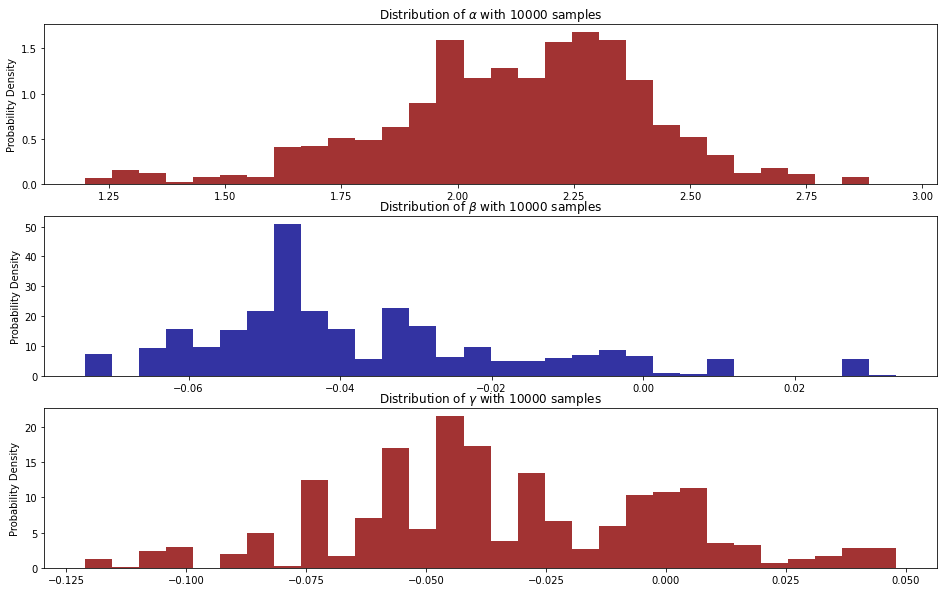

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16, 10))

plt.subplot(311)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')

plt.subplot(313)
plt.title(r"""Distribution of $\gamma$ with %d samples""" % N_SAMPLES)

plt.hist(gamma_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')

plt.subplot(312)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

In [ ]:
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()
gamma_est = gamma_samples.mean()

In [ ]:
#prediction on test data
pred = logistic(small_df_test, beta_est, gamma_est, alpha_est)

In [ ]:
# setting threshold to be 0.5
pred_after_threshold = (pred >= 0.5)*1

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(small_df_test['Response'], pred_after_threshold)

0.8571428571428571